## Implementation - Kevin Vega

In [121]:
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

from keras.layers import Dense
from keras.models import Sequential

from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [122]:
df = pd.read_csv("data/new-york-city-airbnb-open-data/AB_NYC_2019.csv")

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64

In [124]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [125]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Lot's of missing values for `last_review` dates and `reviews_per_month`

In [126]:
# Convert date strings to datetime
df['last_review'] = pd.to_datetime(df.last_review)

Interesting problem arises due to lack of about 20% of date data
* ignore missing
* use another ML algorithm to predict value for missing dates and then run RNN



In [127]:
# Simpler to drop null values
with pd.option_context('mode.use_inf_as_null', True):
    df = df.dropna()

df.isnull().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [128]:
# group prices into categories
# get the prices
prices = df['price']

In [129]:
# get the min and max prices
min_price = prices.min()
max_price = prices.max()

print("MIN: {}, MAX: {}".format(min_price, max_price))

# bin the prices into categories
bins = [0, 2000, 4000, 6000, 8000, 10000]

# category labels ['lo', 'lo_mid', 'mid', 'hi_mid', 'hi']
labels = ['lo', 'lo_mid', 'mid', 'hi_mid', 'hi']

#df['price_range'] = pd.cut(df.price, bins=bins, labels=labels)

MIN: 0, MAX: 10000


In [130]:
#df.head()
#df['price_range'].value_counts()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027376A912E8>]],
      dtype=object)

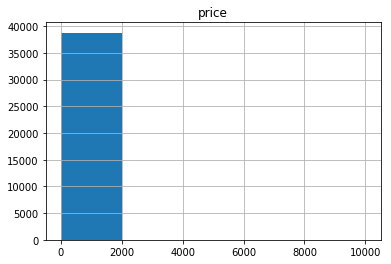

In [131]:
df.hist(column='price', bins=5)

Anything above $2000 looks like an outlier



In [132]:
df_check_prices = df[df.price <= 2000]

In [133]:
new_prices = df_check_prices['price']

In [134]:
# get the min and max prices
new_min_price = new_prices.min()
new_max_price = new_prices.max()

print("MIN: {}, MAX: {}".format(new_min_price, new_max_price))

MIN: 0, MAX: 2000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027376ACDDA0>]],
      dtype=object)

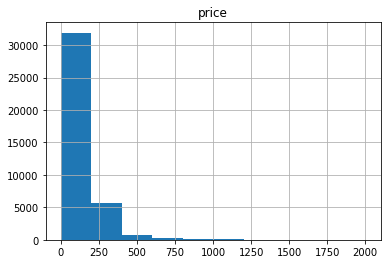

In [135]:
df_check_prices.hist(column='price', bins=10)

Even with values properties priced above $2000 removed, the data is still very unbalanced

Cleaning up the data

## Neural Network

In [136]:
def process_data(file="data/new-york-city-airbnb-open-data/AB_NYC_2019.csv",
                 target='neighbourhood_group', test_size=0.2):
    df = pd.read_csv(str(file))
    
    # Convert date strings to datetime
    df['last_review'] = pd.to_datetime(df.last_review)
    
    # Remove unnecessary data
    df.drop(['id', 'name', 'host_name', 'host_id'], axis=1, inplace=True)
    
    # Convert categorical data to numerical
    le = LabelEncoder()
    df['neighbourhood_group'] = pd.Series(le.fit_transform(df['neighbourhood_group']))
    df['neighbourhood'] = pd.Series(le.fit_transform(df['neighbourhood']))
    df['room_type'] = pd.Series(le.fit_transform(df['room_type']))
    df['last_review'] = pd.Series(le.fit_transform(df['last_review']))
    
    # Remove NaN and non-definite values from table
    with pd.option_context('mode.use_inf_as_null', True):
        df = df.dropna()
    
    # Ensure category values are integer
    df['neighbourhood_group'] = df['neighbourhood_group'].astype(int)
    df['neighbourhood'] = df['neighbourhood'].astype(int)
    df['room_type'] = df['room_type'].astype(int)
    df['last_review'] = df['last_review'].astype(int)
    
    # Separate prices from features
    features_df = df.loc[:, df.columns != str(target)] 
    target_df = df[str(target)]
    
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.2)
    
    # Normalize the data
    X_train = tf.keras.utils.normalize(X_train, axis=1)
    X_test = tf.keras.utils.normalize(X_test, axis=1)
    
    print("Shapes - X_train: {}, X_test: {}".format(X_train.shape, X_test.shape) +
          "\n         y_train: {}. y_test: {}".format(y_train.shape, y_test.shape))
    
    return X_train, X_test, y_train, y_test

In [137]:
def create_model(feature_dim, output_dim, neurons, hidden_layers=1, activation='relu', loss_func='sparse_categorical_crossentropy', optimizer_param='adam',
                output_activation='softmax'):
    model = Sequential()
    
    # Add input layer, with dimensions equal to input features
    model.add(Dense(neurons, input_dim=feature_dim, activation=activation))
    
    for i in range(hidden_layers):
        model.add(Dense(neurons, activation=activation))
        
    model.add(Dense(output_dim, activation=output_activation))
    
    model.compile(optimizer=optimizer_param,
                loss=loss_func,
                metrics=['accuracy'])
    
    return model

In [116]:
def test_models(X_train, X_test, y_train, y_test, output_dim, n_models=4, neurons=8, epochs=100, activation='relu',
               verbose=0, loss_func='sparse_categorical_crossentropy', optimizer_param='adam', output_activation='softmax'):
    
    feature_dim = X_train.shape[1]
    
    models = {}
    
    histories = []
    
    print("{} neuron(s) per hidden layer\n".format(neurons))
    for i in range(n_models):
        models[i] = create_model(feature_dim, output_dim=output_dim, neurons=neurons, hidden_layers=i+1, activation='relu', loss_func=loss_func, optimizer_param=optimizer_param,
                                output_activation=output_activation)
        print("Fitting model: {}, has {} hidden layer(s)".format(i+1, i+1))
        histories.append(models[i].fit(X_train, y_train, epochs=epochs, verbose=verbose))
        print("")
    
    return models, histories

In [55]:
X_train, X_test, y_train, y_test = process_data()

Shapes - X_train: (31074, 11), X_test: (7769, 11)
         y_train: (31074,). y_test: (7769,)


In [81]:
models, histories = test_models(X_train, X_test, y_train, y_test, 5, epochs=10)

Fitting model: 1, has 1 hidden layer(s)

Fitting model: 2, has 2 hidden layer(s)

Fitting model: 3, has 3 hidden layer(s)

Fitting model: 4, has 4 hidden layer(s)



In [108]:
def plot_histories(histories, number_of_neurons, feature_name, save=False):
    
    if type(feature_name) != str:
        print("Please enter desired feature name as string")
        return
    
    for i in range(len(histories)):
        plt.plot(histories[i].history['acc'], label="{}-Hidden Layers".format(i+1))
    plt.title('{} - Model Accuracy, {} neurons per layer'.format(feature_name, number_of_neurons))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    if save:
        plt.savefig("{}-{}-hidden-{}-neurons-acc.png".format(feature_name, i+1, number_of_neurons))
    plt.show()
    
    for i in range(len(histories)):
        plt.plot(histories[i].history['loss'], label="{}-Hidden Layers".format(i+1))
    plt.title('{} - Model Loss, {} neurons per layer'.format(feature_name, number_of_neurons))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    if save:
        plt.savefig("{}-{}-hidden-{}-neurons-loss.png".format(feature_name, i+1, number_of_neurons))
    plt.show()
    

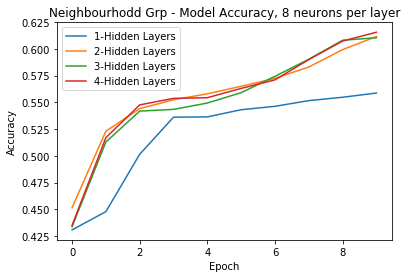

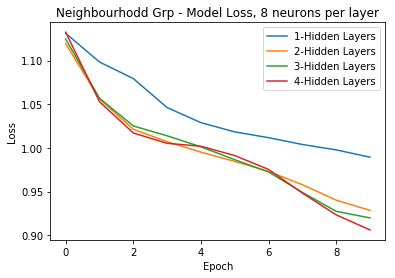

In [103]:
plot_histories(histories, 8, "Neighbourhood Grp")

Shapes - X_train: (31074, 11), X_test: (7769, 11)
         y_train: (31074,). y_test: (7769,)
Fitting model: 1, has 1 hidden layer(s)

Fitting model: 2, has 2 hidden layer(s)

Fitting model: 3, has 3 hidden layer(s)

Fitting model: 4, has 4 hidden layer(s)



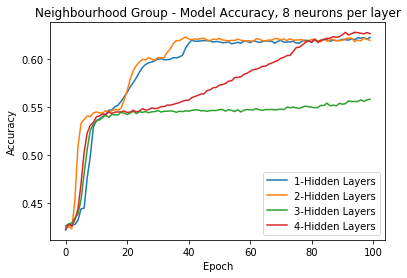

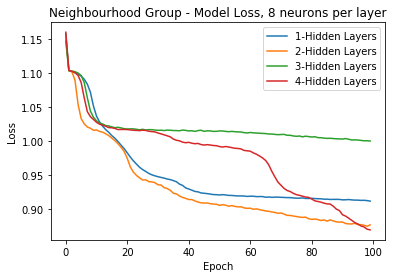

Fitting model: 1, has 1 hidden layer(s)

Fitting model: 2, has 2 hidden layer(s)

Fitting model: 3, has 3 hidden layer(s)

Fitting model: 4, has 4 hidden layer(s)



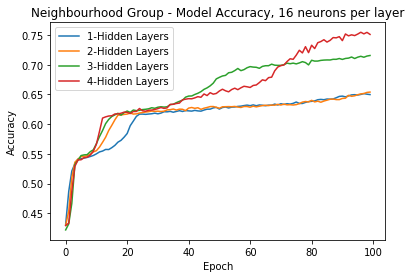

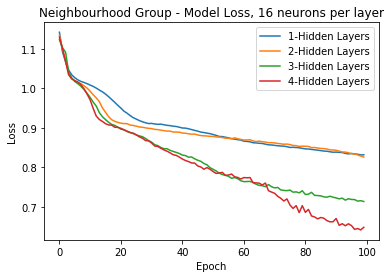

Fitting model: 1, has 1 hidden layer(s)

Fitting model: 2, has 2 hidden layer(s)

Fitting model: 3, has 3 hidden layer(s)

Fitting model: 4, has 4 hidden layer(s)



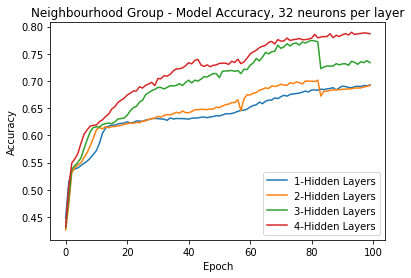

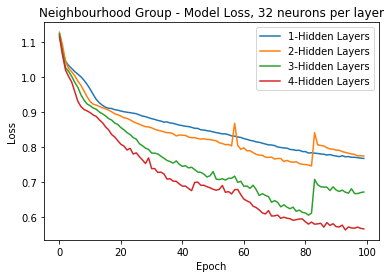

In [109]:
X_train, X_test, y_train, y_test = process_data()

for i in [8, 16, 32]:
    models, histories = test_models(X_train, X_test, y_train, y_test, 5, epochs=100, neurons=i)
    
    plot_histories(histories, i, "Neighbourhood Group", save=True)

In [120]:
def gen_graphs(file, target='neighbourhood_group', output_dim=5, epochs=100, list_of_neurons=[8, 16, 32], loss_func='sparse_categorical_crossentropy',
               optimizer_param='adam', output_activation='softmax', save=False):
    
    X_train, X_test, y_train, y_test = process_data(target=target)

    for i in list_of_neurons:
        models, histories = test_models(X_train, X_test, y_train, y_test, output_dim, epochs=epochs, neurons=i, loss_func=loss_func, optimizer_param=optimizer_param,
                    output_activation=output_activation)

        plot_histories(histories, i, "Price", save=save)